In [1]:
# !pip install -q clu

In [2]:
# # We always start with a dataset to train on. Let's download the tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [3]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

# from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [4]:
# read it in to inspect it
with open('/kaggle/input/shak-new-input/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"&',-.:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
64


In [6]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("unsloth/Phi-3-mini-4k-instruct", padding_side="left")

In [7]:
# text_inputs = tokenizer(text, return_tensors="np")
# data = jnp.array(text_inputs['input_ids'][0])

In [8]:
# vocab_size = tokenizer.vocab_size
# print(vocab_size)

In [9]:
# print(tokenizer.decode((text_inputs['input_ids'][0][0:100]).tolist()))

In [10]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[45, 46, 46, 1, 57, 45, 42, 55, 42]
hii there


In [11]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(2643247,) int32
[17 46 55 56 57  1 14 46 57 46 63 42 51  9  0 13 42 43 52 55 42  1 60 42
  1 53 55 52 40 42 42 41  1 38 51 62  1 43 58 55 57 45 42 55  6  1 45 42
 38 55  1 50 42  1 56 53 42 38 48  8  0  0 12 49 49  9  0 30 53 42 38 48
  6  1 56 53 42 38 48  8  0  0 17 46 55 56 57  1 14 46 57 46 63 42 51  9
  0 36 52 58  1 38 55 42  1 38 49 49  1 55 42 56 52 49 59 42 41  1 55 38
 57 45 42 55  1 57 52  1 41 46 42  1 57 45 38 51  1 57 52  1 43 38 50 46
 56 45 11  0  0 12 49 49  9  0 29 42 56 52 49 59 42 41  8  1 55 42 56 52
 49 59 42 41  8  0  0 17 46 55 56 57  1 14 46 57 46 63 42 51  9  0 17 46
 55 56 57  6  1 62 52 58  1 48 51 52 60  1 14 38 46 58 56  1 24 38 55 40
 46 58 56  1 46 56  1 40 45 46 42 43  1 42 51 42 50 62  1 57 52  1 57 45
 42  1 53 42 52 53 49 42  8  0  0 12 49 49  9  0 34 42  1 48 51 52 60  5
 57  6  1 60 42  1 48 51 52 60  5 57  8  0  0 17 46 55 56 57  1 14 46 57
 46 63 42 51  9  0 23 42 57  1 58 56  1 48 46 49 49  1 45 46 50  6  1 38
 51 41  1 60 42  5 49 49  1 45 38 

In [12]:
data

Array([17, 46, 55, ..., 38, 62,  8], dtype=int32)

In [13]:
len(data)/64/32

1290.64794921875

In [14]:
# train_test_split = 0.9
# n = int(train_test_split*len(data))
# train_data = data[:n]
# test_data = data[n:]

train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [15]:
block_size = 8
train_data[:block_size+1]

Array([17, 46, 55, 56, 57,  1, 14, 46, 57], dtype=int32)

In [16]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [17] the target: 46
when input is [17 46] the target: 55
when input is [17 46 55] the target: 56
when input is [17 46 55 56] the target: 57
when input is [17 46 55 56 57] the target: 1
when input is [17 46 55 56 57  1] the target: 14
when input is [17 46 55 56 57  1 14] the target: 46
when input is [17 46 55 56 57  1 14 46] the target: 57


In [17]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 15000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 256
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 6
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16
n_tokens = 1

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + n_tokens, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[31 16 30 ... 20 25 14]
 [44 43 58 ...  1 38 44]
 [42 56  6 ... 52 55 56]
 ...
 [ 6  1 39 ... 25 52 57]
 [46 41 46 ... 56 60 52]
 [57 52  1 ... 49 52 55]]
targets:
(128, 64)
[[16 30 30 ... 25 14 16]
 [43 58 49 ... 38 44 38]
 [56  6  1 ... 55 56 42]
 ...
 [ 1 39 42 ... 52 57 45]
 [41 46 58 ... 60 52 55]
 [52  1 50 ... 52 55 41]]


In [18]:
print(xb[0])
print(yb[0])

[31 16 30 30  9  0 34 45 52  1 48 51 52 40 48 56  1 56 52  1 49 52 58 41
  1 38 57  1 41 52 52 55 11  1 23 52 52 48  1 57 52  1 57 45  5  1 41 52
 52 55  1 57 45 42 55 42  6  0  0 27 29 20 25 14]
[16 30 30  9  0 34 45 52  1 48 51 52 40 48 56  1 56 52  1 49 52 58 41  1
 38 57  1 41 52 52 55 11  1 23 52 52 48  1 57 52  1 57 45  5  1 41 52 52
 55  1 57 45 42 55 42  6  0  0 27 29 20 25 14 16]


In [19]:
# hidden_state = [jnp.zeros((1,n_latent_dim, n_embd * expans)) for _ in range(n_layers)]
# hidden_state[0].shape

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [20]:
class Mamba(nn.Module):

    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Conv(features=n_embd, kernel_size=conv_k_size,padding=1) #nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)

        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
        self.D = 0.1*self.param('D', jax.random.normal, (1, 1,emb_features, block_size))
        self.delta = 0.05*self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

        self.out_proj = nn.Dense(n_embd // n_heads)
        
        self.hidden_state = self.variable('other_variables','hidden_state', 
                                          jnp.zeros, 
                                          (1,n_latent_dim, emb_features))
#         self.rms_norm = nn.RMSNorm()

    def __call__(self, embeds):
        x = self.in_proj1(embeds)
        x = jax.nn.silu(x) #new
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)

#         x = self.rms_norm(x)

        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.B * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        a_, b_ = self.discretize()
        h = 0
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            
#         for l in range(x.shape[-1]):
#             print(self.C.shape, h.shape)

        y = ((self.C * jax.lax.expand_dims(h,[3])).sum(1, keepdims=True) + self.D*x)
        
#         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return y

In [21]:
class MultiHeadMamba(nn.Module):
    def setup(self):
        self.heads = [Mamba() for _ in range(n_heads)]
        self.rms_norm = nn.RMSNorm()

    def __call__(self, x):
        out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
        x = self.rms_norm(out)
        return x

In [22]:
# class FeedForward(nn.Module):
#     def setup(self):
#         self.ffn = nn.Sequential([
#             nn.Dense(4 * n_embd),
#             nn.relu,
#             nn.Dense(n_embd)]
#         )
#     def __call__(self, x):
#         return self.ffn(x)

In [23]:
# class MambaBlock(nn.Module):
#     def setup(self):
#         self.mamba_block = Mamba()
#         self.ln1 = nn.RMSNorm()
#         self.ffn = FeedForward()
#         self.ln2 = nn.LayerNorm()

#     def __call__(self, x):
#         x = x + self.mamba_block(self.ln2(x))
#         x = x + self.ffn(self.ln1(x))
#         return x


In [24]:
# class MambaModel(nn.Module):

#     def setup(self):
#         self.tok_embeddings = nn.Embed(vocab_size, n_embd)
#         self.pos_embeddings = nn.Embed(block_size, n_embd)
#         self.ln = nn.LayerNorm()
#         self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
#         self.preds_out = nn.Dense(vocab_size)

#     def __call__(self, x, training: bool):
#         x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
# #         x = self.ln(x)
#         for layer in self.mamba_layers:
#             x = layer(x)
            
#         return self.preds_out(x)

#     @jax.jit
#     def generate(self, idx, max_new_tokens, params):
#     # idx is (B, T) array of indices in the current context
#         for _ in range(max_new_tokens):
#             # crop idx to the last block_size tokens
#             idx_cond = idx[:, -block_size:]
#             # get the predictions
#             logits = self.apply(params, idx_cond)
#             # focus only on the last time step
#             logits = logits[:, -1, :] # becomes (B, C)
#             # apply softmax to get probabilities
#             ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
#             # sample from the distribution
#             idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
#             # append sampled index to the running sequence
#             idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
#     #         print(idx_next)
#     #         print(idx)

#         return idx

In [25]:
# model = Mamba()
# params = model.init(jax.random.key(42), jnp.ones((1,64,256)))
# # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# # print(model.tabulate(jax.random.key(0), jnp.ones((1,64,256)),
# #                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, jnp.ones((1,64,256)), mutable=['other_variables'])
# # # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# xb.shape, xs[0].shape, xs[1].keys()

In [26]:
# print(xs[1]['other_variables']['hidden_state'].shape, xs[1]['other_variables']['hidden_state'].min(), xs[1]['other_variables']['hidden_state'].max())

In [27]:
# xfs = model.apply(params, 2*jnp.ones((1,64,256)), mutable=['other_variables'])
# print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# print(xfs[1]['other_variables']['hidden_state'].shape, xfs[1]['other_variables']['hidden_state'].min(), xfs[1]['other_variables']['hidden_state'].max())

In [28]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [29]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(self.block_size))
        
        for i in range(self.num_layers):
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )
    
            x = x + Mamba()(nn.RMSNorm()(x))

#             x = x + nn.Sequential([
#               nn.Dense(4 * self.embed_size),
#               nn.relu,
#               nn.Dropout(self.dropout_rate, deterministic=not training),
#               nn.Dense(self.embed_size),
#             ])(nn.RMSNorm()(x))

        x = nn.Dense(self.vocab_size)(nn.RMSNorm()(x))
        return x

In [30]:
# key = jax.random.key(42)

# # fin_model = MambaModel()
# # fin_params = fin_model.init(key, xb, training=False)


# fin_model = NanoLM(
#     vocab_size=vocab_size,
#     num_layers=n_layers,
#     num_heads=8,
#     head_size=32,
#     dropout_rate=0.2,
#     embed_size=n_embd,
#     block_size=block_size,
# )

# fin_params = fin_model.init(
#     {'params': key},
#     jnp.ones((batch_size, block_size), dtype=jnp.int32),
#     training=False
# )

# n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = fin_model.apply(fin_params, xb, training=False)[0]
# xb.shape, xf.shape

In [31]:
def loss_fun(params, x, y, var_params,dropout_key):
    logits, updated_variables = model.apply({'params': params, **var_params}, x, training=True, rngs={"dropout": dropout_key}, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), (updated_variables, accuracy)

@jax.jit
def eval_step(params, x, y, var_params):
    logits, _ = model.apply({'params': params, **var_params}, x, training=False, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [32]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

model = NanoLM(
    vocab_size=vocab_size,
    num_layers=n_layers,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=n_embd,
    block_size=block_size,
)

var_params = model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)
print(var_params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

dict_keys(['params', 'other_variables'])
Total number of parameters: 5_675_840


In [33]:
var_params['params']['Embed_0']['embedding'].shape

(64, 256)

In [34]:
params = var_params.pop('params')

In [35]:
var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)

In [36]:
# decay_rate = 0.96
# learning_rate_schedule = optax.exponential_decay(learning_rate, decay_rate, max_iters//1000)
opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [37]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, var_params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, aux_data), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, var_params, subkey)
    var_params, train_accuracy = aux_data
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, var_params, train_accuracy

# for i in tqdm(range(max_iters)):
counter = 0
loss = 10
while counter<max_iters: # and loss > 1.0:

    params, key, opt_state, loss, var_params, train_accuracy = step(key, params, var_params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if counter % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data), var_params)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('##########################################################')
        print("Step: ", counter,"\t Train Loss: ", loss,"\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", counter,"\t Eval Loss: ", eval_loss,"\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
    counter += 1
        

##########################################################
Step:  0 	 Train Loss:  4.6607275 	 Train Accuracy:  1.32%
Step:  0 	 Eval Loss:  4.315344 	 Eval Accuracy:  3.33%
##########################################################
Step:  100 	 Train Loss:  0.061989706 	 Train Accuracy:  98.79%
Step:  100 	 Eval Loss:  0.065420985 	 Eval Accuracy:  98.66%
##########################################################
Step:  200 	 Train Loss:  0.036058284 	 Train Accuracy:  99.11%
Step:  200 	 Eval Loss:  0.04527366 	 Eval Accuracy:  98.83%
##########################################################
Step:  300 	 Train Loss:  0.03766068 	 Train Accuracy:  99.05%
Step:  300 	 Eval Loss:  0.039712146 	 Eval Accuracy:  98.89%
##########################################################
Step:  400 	 Train Loss:  0.035780817 	 Train Accuracy:  99.01%
Step:  400 	 Eval Loss:  0.03439277 	 Eval Accuracy:  99.06%
##########################################################
Step:  500 	 Train Loss:  0.02

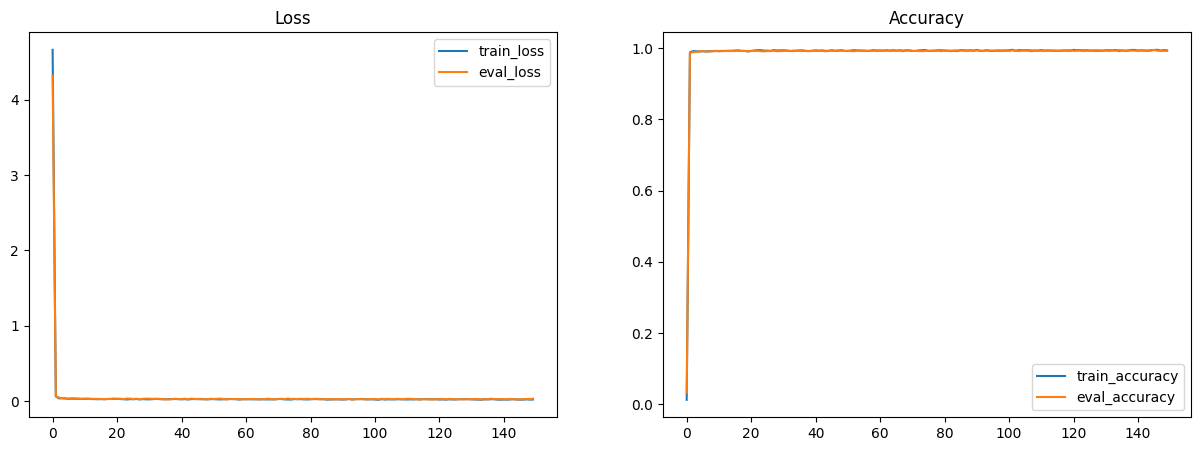

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [39]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, var_params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = model.apply({'params': params, **var_params}, context, training=False, mutable=['other_variables'])[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -n_tokens, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        print(context.shape)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.expand_dims(test_data[850:850+block_size], axis=0)),
    (),
    length=length,
    )
    return new_tokens

In [40]:
test_data[850:850+block_size]

Array([58, 41,  1, 12, 57, 45, 42, 51, 56,  1, 52, 51,  1, 38,  1, 45, 42,
       38, 53,  7,  0,  0, 31, 20, 24, 26, 25,  9,  0, 34, 38, 55,  5, 56,
       57,  1, 57, 45, 52, 58,  1,  5, 44, 38, 46, 51, 56, 57,  1, 12, 57,
       45, 42, 51, 56, 11,  0,  0, 12, 23, 14, 20, 13, 20], dtype=int32)

In [41]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, var_params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

(1, 64)
[12, 15, 16, 30, 31, 16, 29, 9, 0, 12, 45, 6, 1, 57, 45, 38, 57, 1, 46, 57, 1, 60, 42, 51, 52, 58, 55, 1, 57, 45, 46, 56, 1, 53, 58, 55, 53, 42, 40, 57, 1, 62, 52, 58, 57, 45, 1, 45, 42, 55, 1, 50, 52, 55, 42, 6, 0, 0, 17, 20, 29, 30, 31, 1, 27, 16, 29, 16, 29, 20, 14, 22, 9, 0, 18, 58, 46, 41, 42, 55, 8, 0, 0, 13, 20, 12, 25, 14, 12, 9, 0, 13, 42, 46, 51, 44, 1, 52, 43, 1, 57, 45, 42, 1, 22, 46, 51, 44, 8, 0, 0, 12, 25, 31, 26, 25, 36, 9, 0, 20, 5, 49, 49, 1, 45, 42, 1, 50, 58, 56, 57, 1, 56, 53, 52, 55, 57, 1, 38, 41, 52, 1, 53, 55, 52, 56, 53, 42, 55, 1, 56, 52, 6, 1, 56, 46, 51, 40, 42, 1, 20, 1, 38, 50, 1, 46, 51, 1, 45, 42, 55, 5, 56, 57, 1, 33, 38, 55, 56, 52, 10, 0, 34, 45, 52, 50, 1, 62, 52, 58, 1, 60, 46, 49, 49, 1, 51, 52, 60, 1, 51, 52, 1, 49, 46, 40, 57, 46, 52, 51, 1, 45, 46, 57, 45, 42, 55, 8, 1, 26, 2, 0, 0, 12, 23, 23, 9, 0, 30, 46, 55, 6, 1, 51, 52, 60, 1, 20, 1, 53, 55, 52, 49, 52, 58, 55, 10, 0, 26, 55, 1, 40, 52, 58, 51, 57, 1, 45, 46, 50, 1, 52, 58, 57, 1,

In [42]:
dsfsdhfgjdg hfdgjdgjgfjhs'####################

SyntaxError: unterminated string literal (detected at line 1) (2630675753.py, line 1)

In [ ]:
len(token_gen)

In [ ]:
idx = 882
tokenizer.decode(test_data[idx:idx+32])

In [ ]:
tokenizer('bestopleled', return_tensors='np')

In [ ]:
tokenizer.decode([1991])

In [ ]:
params['Dense_12']['kernel'].shape

In [ ]:
rngk = jax.random.PRNGKey(389)
xs, ys = get_batch(rngk, train_data)
print(xs[0])
print(ys[0])

In [ ]:
logits = model.apply({'params': params, **var_params}, xs[0].reshape((1,64)), training=False, mutable=['other_variables'])[0]
rng, rng_subkey = jax.random.split(rngk)
for pso in range(n_tokens):
    new_token = jax.random.categorical(
      rng_subkey, logits[:, -1*(n_tokens-pso), :], axis=-1, shape=(1, 1)
    )
    print(new_token)

In [ ]:
pred_tok = [51,49,46,46,46,52]
print(decode(ys[0].tolist()))

In [ ]:
act_tk = [60, 43, 50, 57,  1, 47]
print(decode(act_tk))

In [ ]:
jax.nn.standardize(jnp.array([2.0,3.0,4.0]))

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), 
                         training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [ ]:
TrainState.create(

In [ ]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, 
                                rngs={"dropout": key})[0]
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)[0]
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [ ]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
SEED = 442
key = jax.random.PRNGKey(SEED)
loss = 10
counter = 0
# for step in tqdm(range(max_iters)): # increase number of steps for good results...
while counter==max_iters or loss > 1.0:

      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)

    key = (jax.random.split(key)[0])

    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [ ]:

logits = fin_model.apply(fin_params, xb, training=False)[0]
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

In [ ]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)

#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)


#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [ ]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [ ]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

In [ ]:
sdgh  fs

In [ ]:
state.params

In [ ]:
!pip install mamba-ssm

In [ ]:
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def create_torch(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [ ]:
import selective_scan_cuda

xx, aa, bb, cc, ddelta = create_torch()
y_from_repo = selective_scan_cuda.fwd(xx.squeeze(1), ddelta.squeeze(1), aa[0].squeeze(-1).T, bb.squeeze(-2)[:, None, :, :], cc.squeeze(-2)[:, None, :, :], None, None, None, False)
y_from_repo

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def ssm(x, a, b, c, delta):
    "Jax Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdims=True))
    return h, jnp.stack(y, -1)


In [ ]:
_, y_ = ssm(xx.cpu().numpy(), aa.cpu().numpy(), bb.cpu().numpy(), cc.cpu().numpy(), ddelta.cpu().numpy())

In [ ]:
from mamba_ssm import Mamba as Mamba_T
torch_mamba = Mamba_T(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embd, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
)

In [ ]:
xm = x = rand((1, 1, n_embd, 32))
xm.shape

In [ ]:
torch_mamba(xm.squeeze(1))

In [ ]:
torch_mamba.in_proj

In [ ]:
from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

In [ ]:
def tokenise_prompts(prompt):
    inputs = []
    for tokenizer in [tokenizer_1, tokenizer_2]:
        text_inputs = tokenizer(
            positive_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        inputs.append(text_inputs.input_ids)
    return jnp.stack(inputs, axis=1)

In [ ]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        print(x.shape)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        print(x.shape)
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        print(x.shape)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        print(x.shape)
        x = x.reshape((x.shape[0], -1))  # flatten
        print(x.shape)
        x = nn.Dense(features=256)(x)
        print(x.shape)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        print(x.shape)
        return x

In [ ]:
rng = jax.random.PRNGKey(20)
cnn = CNN()
params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']

In [ ]:
class Conv1d(nn.Module):
    """A simple 1D CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Embed(65, 256)(x) + nn.Embed(64, 256)(jnp.arange(64))
        print(x.shape)
#         x = nn.Dense(features=512)(x)
#         print(x.shape)
        x = nn.Conv(features=256, kernel_size=3, padding=1)(x)
        print(x.shape)
        x = nn.avg_pool(x, window_shape=(2,), strides=(2,))
        print(x.shape)
        x = nn.Conv(features=512, kernel_size=3, padding=1)(x)
        print(x.shape)
        x = nn.avg_pool(x, window_shape=(2,), strides=(2,))
        print(x.shape)
        x = nn.ConvTranspose(features=512, kernel_size=2, padding='same')(x)
        print(x.shape)
        x = nn.Dense(features=65)(x)
        print(x.shape)
        return x

In [ ]:
rng = jax.random.PRNGKey(204)
mycon1d = Conv1d()
params = mycon1d.init(rng, jnp.ones((1, 64), dtype=jnp.int32))['params']